# Predicting Covid-19 infection from Chest X-Rays

Author **Vishal Sharma**


In [ ]:
import os
import pandas as pd 
import cv2                 
import numpy as np         
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
import matplotlib.pyplot as plt

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import numpy as np
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
# K.image_data_format()
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

## Data Preprocessing

**Data Description**

Train dataset has 100 Covid-19 X-Ray Images and 3000 Non-covid X-Ray Images

Test Dataset has 84 Covid-19 X-Ray Images and 500 Non-Covid X-Ray Images

As dataset is highly imbalanced so we have to generate more images using image augmentation techniques to balance the dataset.

In [ ]:
# os.chdir('/content/drive/My Drive/covid19_cxr')
# !unzip -q data_upload_v2.zip

In [ ]:
print(os.listdir('/content/drive/My Drive/covid19_cxr/data_upload_v2'))

['test', 'train']


In [ ]:
print(os.listdir("/content/drive/My Drive/covid19_cxr/data_upload_v2/train/"))

['non', 'covid']


In [ ]:
train_dir = "/content/drive/My Drive/covid19_cxr/data_upload_v2/train/"
test_dir = "/content/drive/My Drive/covid19_cxr/data_upload_v2/test/"

Firstly, I tried to create new images by these augmentation techniques:


*   Random Zoom
*   Random Sheer
*   Split each image to 3 images (R, G, B)

But these resulted in poor accuracy(60%) on model. One explanation to this is that these techniques are pixel level transformations and Chest X-Ray data is very sensitive to these transformations.

So, I have used image augmentation techniques which does not have much effects on image pixels like flip, mirror, blur, etc.

In [ ]:
'''
import os
from PIL import Image, ImageOps
from PIL import ImageFilter

# filelist = train_dir['covid'].loc[(1)].tolist()
# print(filelist)
for count in range(0,2):
  Dir = train_dir + '/covid'
  #   for imagefile in filelist:
  for imagefile in os.listdir(Dir):
      os.chdir('/content/drive/My Drive/covid19_cxr/data_upload_v2/train/covid')
      im=Image.open(imagefile)
      im_blur=im.filter(ImageFilter.GaussianBlur)
      im_unsharp=im.filter(ImageFilter.UnsharpMask)
      im_flip = ImageOps.flip(im)
      im_mirror = ImageOps.mirror(im)
      im_flip.save(str(count)+'mir_'+imagefile)
      im_mirror.save(str(count)+'mir_'+imagefile)
      im_blur.save(str(count)+'bl_'+imagefile)
      im_unsharp.save(str(count)+'un_'+imagefile)
'''

In [ ]:

train_datagen = ImageDataGenerator(   rescale=1./255
                                      rotation_range=15,
                                      horizontal_flip=True,
                                      fill_mode='nearest')


test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(299,299),
                                                    class_mode='categorical',
                                                    shuffle = True)

test_generator = test_datagen.flow_from_directory(  test_dir,
                                                    target_size=(299,299),
                                                    class_mode='categorical',
                                                    shuffle = False)

Found 4600 images belonging to 2 classes.
Found 664 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'covid': 0, 'non': 1}

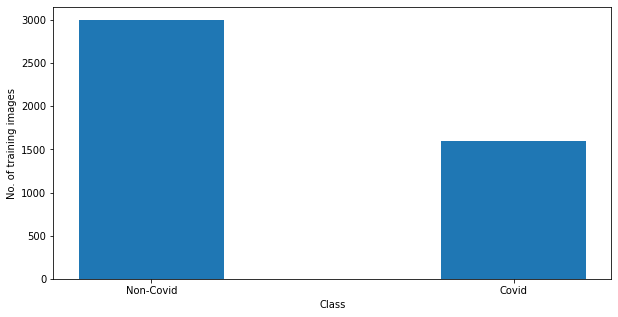

In [ ]:
data = {'Non-Covid':3000, 'Covid':1600} 
courses = list(data.keys()) 
values = list(data.values()) 
   
fig = plt.figure(figsize = (10, 5)) 
  
# creating the bar plot 
plt.bar(courses, values,  
        width = 0.4) 
  
plt.xlabel("Class") 
plt.ylabel("No. of training images") 
plt.show() 

In [ ]:
covid_images = os.listdir(train_dir + "covid")
noncovid_images = os.listdir(train_dir + "non")

(Left) - Non covid Vs (Right) - covid
-----------------------------------------------------------------------------------------------------------------------------------


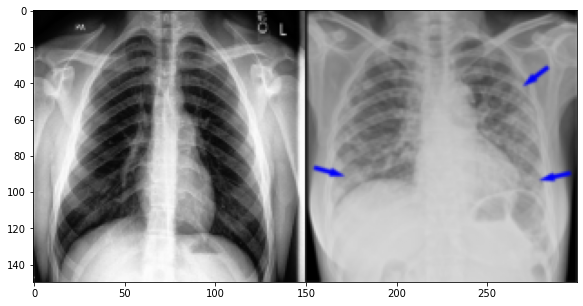

(Left) - Non covid Vs (Right) - covid
-----------------------------------------------------------------------------------------------------------------------------------


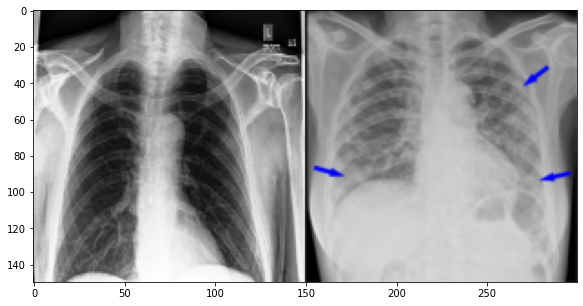

(Left) - Non covid Vs (Right) - covid
-----------------------------------------------------------------------------------------------------------------------------------


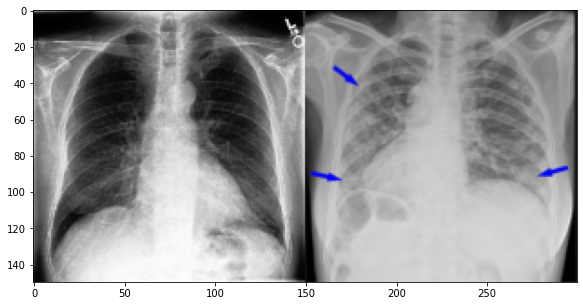

(Left) - Non covid Vs (Right) - covid
-----------------------------------------------------------------------------------------------------------------------------------


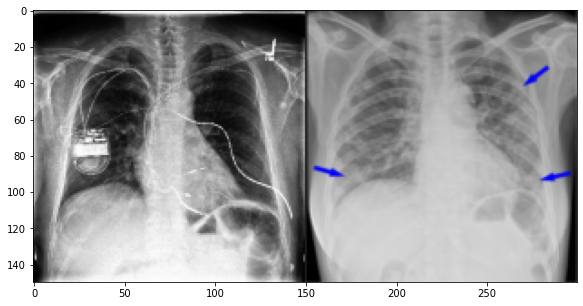

(Left) - Non covid Vs (Right) - covid
-----------------------------------------------------------------------------------------------------------------------------------


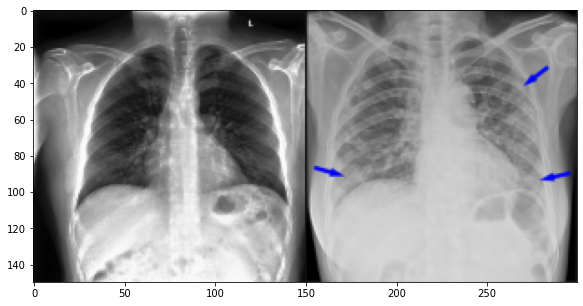

In [ ]:
def plotter(i):
    imagep1 = cv2.imread(train_dir+"covid/"+covid_images[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(train_dir+"non/"+noncovid_images[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - Non covid Vs (Right) - covid")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(5,10):
    plotter(i)

## Model Building

In [ ]:
from keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False , input_shape=(299, 299, 3))

After trying multiple variants of transfer learning(freezing/unfreezing) it was found that freezing all layers except top produced the best result.

In [ ]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='softmax')(x)
# model=Sequential()
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(128,activation='relu'))
# model.add(Dense(2,activation='sigmoid'))

I have used softmax here it is categorical classification and it also outputs probability

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

In [ ]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
Image(model_to_dot(model, show_shapes=True).create_png())

In [ ]:
print(model.summary())

## Model Training

In [ ]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

Dynamic Learning Rate was used which decreases learning rate if after one epoch validation accuracy was not increased.

In [ ]:
filepath="my_model_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

Saving model checkpoints which had best train accuracy.

In [ ]:
batch_size = 64
epochs = 10

Chose batch size 64 after experimenting with batch_size as 16, 32, 64 and 128.

In [ ]:
history = model.fit(train_generator, validation_data = test_generator ,callbacks=[lr_reduce,checkpoint] ,
          epochs=epochs)

Epoch 1/10
144/144 [==============================] - ETA: 0s - loss: 0.1137 - accuracy: 0.9628
Epoch 00001: val_accuracy improved from -inf to 0.89759, saving model to my_model_weights.h5
144/144 [==============================] - 93s 645ms/step - loss: 0.1137 - accuracy: 0.9628 - val_loss: 0.6418 - val_accuracy: 0.8976
Epoch 2/10
144/144 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9824
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00002: val_accuracy did not improve from 0.89759
144/144 [==============================] - 90s 625ms/step - loss: 0.0496 - accuracy: 0.9824 - val_loss: 179.2534 - val_accuracy: 0.8449
Epoch 3/10
144/144 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 0.9970
Epoch 00003: val_accuracy improved from 0.89759 to 0.97892, saving model to my_model_weights.h5
144/144 [==============================] - 92s 636ms/step - loss: 0.0142 - accuracy: 0.9970 - val_loss: 0.0537 - val

## Model Evaluation

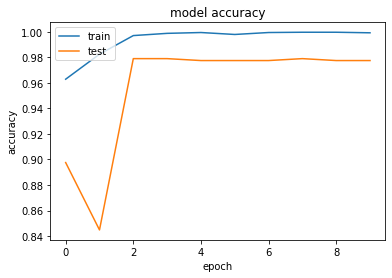

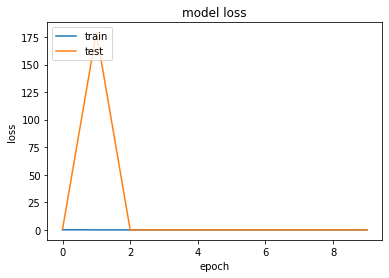

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

A good validation strategy in such cases would be to do k-fold cross-validation, but this would require training k models for every evaluation round.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
Y_pred = model.predict_generator(test_generator, 664)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

Confusion Matrix
[[ 74  10]
 [  5 575]]


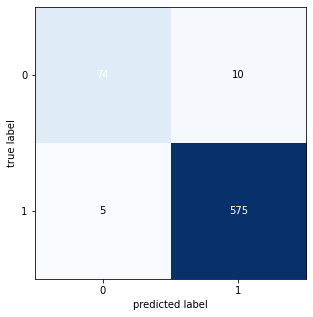

In [ ]:
CM = confusion_matrix(test_generator.classes, y_pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()


In [ ]:
print(classification_report(test_generator.classes, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91        84
           1       0.98      0.99      0.99       580

    accuracy                           0.98       664
   macro avg       0.96      0.94      0.95       664
weighted avg       0.98      0.98      0.98       664



In [ ]:
model.save("/content/drive/My Drive/covid19_cxr/covid19.hdf5")